# Convolutional Neural Networks from Scratch with Live Code

In this lecture, we will discuss **Convolutional Neural Networks** in detail and code a CNN model from scratch. Students shall also have the ability to utilize the "Live Code" feature in this website to interact with python code for in-depth understanding.

<div>
<iframe src="https://slides.com/naresh-ub/cnns/embed" width="100%" height="500" title="Test Title" scrolling="no" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe>
</div>

## What is an Image?

An image is made up of a grid of tiny squares called [pixels](https://en.wikipedia.org/wiki/Pixel#:~:text=In%20digital%20imaging%2C%20a%20pixel,can%20be%20manipulated%20through%20software.). Each pixel holds a bit of color and brightness, and when you put them all together, they form the full picture you see. For grayscale images, each pixel holds intensity values that range from $0$ to $255$. `Matplotlib` is a nice tool to plot images on 2D axes.

Let's explore and learn more about images.

In [ ]:
## ALL OF THESE ARE HELPER FUNCTIONS ##

from pyodide.http import pyfetch
from io import BytesIO
import imageio.v3 as iio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

async def read_img_from_url(url: str):
    """
    Fetches an image from the given URL using pyfetch and returns it as a NumPy array.
    """
    response = await pyfetch(url=url, method="GET")
    raw_bytes = await response.bytes()
    img_array = iio.imread(BytesIO(raw_bytes), index=None)
    return img_array

def rgb_to_grayscale(img_array: np.ndarray) -> np.ndarray:
    """
    Convert an RGB image (H, W, 3) to grayscale (H, W).
    """
    img = Image.fromarray(img_array)
    gray = img.convert("L")
    return np.array(gray)

def img_resize(img, size = (256, 256)):
  return cv2.resize(img, size, interpolation=cv2.INTER_AREA).astype(np.uint8)

def plot_images_grid(images, titles=None, images_per_row=2, figsize=(12, 6), cmap = None):
    num_images = len(images)
    num_rows = (num_images + images_per_row - 1) // images_per_row
 
    plt.figure(figsize=figsize)
    
    for idx, img in enumerate(images):
        plt.subplot(num_rows, images_per_row, idx + 1)
        plt.imshow(img, cmap=cmap)
        if titles and idx < len(titles):
            plt.title(titles[idx])
        img_shape = f"{img.shape[0]}x{img.shape[1]}"
        plt.xlabel(f"Shape: {img_shape}", fontsize=9)
        plt.axis('off')
 
    plt.tight_layout()
    plt.show()
    
from skimage.data import camera
import numpy as np

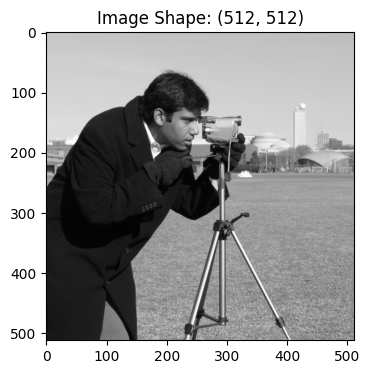

In [3]:
# Camera is a grayscale image from skimage
img = camera().astype(np.float32) # example image

plt.figure(figsize=(4, 4))
plt.imshow(img, cmap="gray")
plt.title(f"Image Shape: {img.shape}") 
plt.show()

In the above plot, we see an example image of shape $(512, 512)$. This denotes that the image is a grayscale image (2-dimensional). If we take a closer look at some regions of the image we see that each pixel contains intensity values from $0$ to $255$.

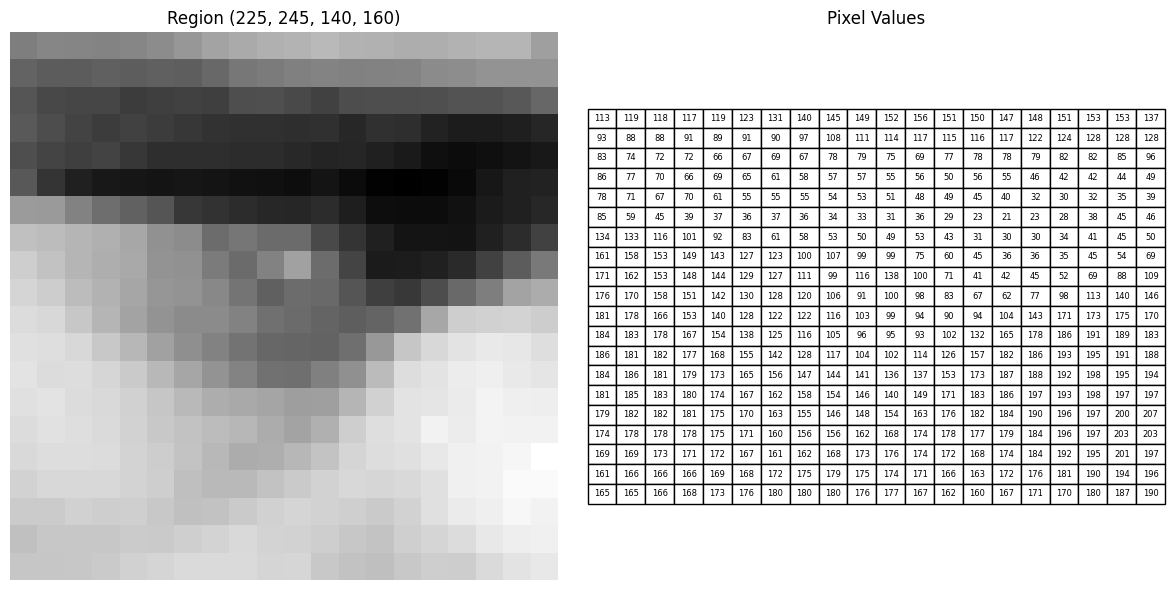

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import camera

# Load image
img = camera().astype(np.float32)

# Define your crop region as a tuple: (x_start, x_end, y_start, y_end)
coords = (225, 245, 140, 160)  # adjust as needed

# Unpack and crop
x_start, x_end, y_start, y_end = coords
region = img[y_start:y_end, x_start:x_end].astype(int)

# Plot: left = cropped region, right = pixel values grid
fig, (ax_img, ax_table) = plt.subplots(1, 2, figsize=(12, 6))

# Left: image region
ax_img.imshow(region, cmap='gray')
ax_img.set_title(f'Region {coords}')
ax_img.axis('off')

# Right: table of pixel values
ax_table.axis('off')
table = ax_table.table(
    cellText=region.tolist(),
    cellLoc='center',
    loc='center'
)
table.scale(1, 1)
ax_table.set_title('Pixel Values')

plt.tight_layout()
plt.show()

## Recap of a Convolution Operation on an Image

Convolution is an operation that “slides” a small kernel $K$ over an image $I$. At each location $(i,j)$, you take a weighted sum of the pixels under the kernel to produce the output pixel $O(i,j)$.

### Discrete Formula


$$
I \in \mathbb{R}^{H \times W}, 
\quad
K \in \mathbb{R}^{(2r+1) \times (2r+1)}, 
\quad
r = \frac{k-1}{2}.
$$  

The convolution $O = I * K$ is defined by  

$$
O(i,j)
=
\sum_{u=-r}^{r} \sum_{v=-r}^{r}
I\bigl(i+u,\,j+v\bigr)\;K\bigl(-u,\,-v\bigr),
$$

for $i = 0, \dots, H-1$ and $j = 0, \dots, W-1$.

> **Note:** The indices $(-u,-v)$ indicate that the kernel is flipped both horizontally and vertically.

```{admonition} Why Flip the Kernel?
:class: note, dropdown, closed

1. **Mathematical Consistency**  
   Flipping makes convolution commutative: 

   $$
   I * K = K * I,
   $$  

   which is important for many theoretical results (e.g., convolution theorems in Fourier analysis).

2. **System Response Interpretation**  
   In signal processing, convolution represents the response of a system with impulse response $K$. Flipping aligns the “past” and “future” contributions correctly.

3. **Distinction from Cross-Correlation**  
   If you omit the flip and write  

   $$
   \sum_{u=-r}^{r} \sum_{v=-r}^{r}
   I(i+u,\,j+v)\;K(u,v),
   $$  

   you get **cross-correlation** instead of convolution. Cross-correlation measures similarity, while convolution implements filtering.

Putting it all together, the flip ensures both the desired mathematical properties (commutativity, associativity) and the correct interpretation of the kernel as an impulse response.
```

```{admonition} Convolution with Stride and Padding
:class: tip, dropdown, closed 

- **Convolution with Stride and Padding**
  
$$
I \in \mathbb{R}^{H \times W}, \quad
K \in \mathbb{R}^{k \times k}, \quad
s \in \mathbb{N} \ (\text{stride}), \quad
p \in \mathbb{N} \ (\text{padding}).
$$

- **Padded Image**

We surround $I$ with a border of $p$ zeros on all sides to form  
$I_{\text{pad}} \in \mathbb{R}^{(H+2p) \times (W+2p)}$, defined by

$$
I_{\text{pad}}(x,y) =
\begin{cases}
I(x - p,\, y - p), & \text{if } 0 \leq x - p < H,\; 0 \leq y - p < W, \\
0, & \text{otherwise}.
\end{cases}
$$

- **Output Dimensions**

The output $O \in \mathbb{R}^{H_{\text{out}} \times W_{\text{out}}}$ has

$$
H_{\text{out}} = \left\lfloor \frac{H + 2p - k}{s} \right\rfloor + 1, \quad
W_{\text{out}} = \left\lfloor \frac{W + 2p - k}{s} \right\rfloor + 1.
$$

- **Convolution Operation**

Slide $K$ in steps of $s$ over $I_{\text{pad}}$:

$$
O(i,j) =
\sum_{u=0}^{k-1} \sum_{v=0}^{k-1}
I_{\text{pad}}(i \times s + u,\, j \times s + v) \times K(u,v),
$$

for $i = 0, \dots, H_{\text{out}}-1$ and $j = 0, \dots, W_{\text{out}}-1$.

---

- **Why These Matter**

- **Stride $s$:**  
  Controls how far the kernel jumps each time.  
  - $s=1$: full resolution  
  - $s>1$: downsampling (reduces output size and computation)

- **Padding $p$:**  
  Includes border pixels and controls output size.  
  - $p=0$: no padding (shrinks output)  
  - $p = \frac{k-1}{2}$ (for odd $k$): preserves input size (“same” convolution).
```  

```{figure} https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif
---
name: conv_demo
align: center
---
Convolution Example
```

### Convolution on 2D images Code

Test with different kernels to understand what features are extracted by convolution operations.

In [5]:
def pad_image(image, padding):
    """
    Zero-pad a 2D image.
    """
    return np.pad(image, pad_width=padding, mode='constant', constant_values=0)

def convolve2d(image, kernel, stride=1, padding=0):
    """
    Perform 2D convolution with optional stride and zero-padding.

    Args:
        image (np.ndarray): Grayscale image (H x W)
        kernel (np.ndarray): Convolution kernel (k x k)
        stride (int): Stride for sliding the kernel
        padding (int): Zero-padding size

    Returns:
        np.ndarray: Convolved output image
    """
    # Flip the kernel for convolution (not needed for cross-correlation)
    kernel = np.flipud(np.fliplr(kernel))

    # Pad the image
    if padding > 0:
        image = pad_image(image, padding)

    H, W = image.shape
    kH, kW = kernel.shape

    # Compute output dimensions
    out_H = (H - kH) // stride + 1
    out_W = (W - kW) // stride + 1

    # Initialize output
    output = np.zeros((out_H, out_W), dtype=np.float32)

    # Perform convolution
    for i in range(out_H):
        for j in range(out_W):
            region = image[i*stride:i*stride+kH, j*stride:j*stride+kW]
            output[i, j] = np.sum(region * kernel)

    # Normalize output to range [0, 255] for display
    output = np.clip(output, 0, 255)

    return output

# 1. Identity (no change)
identity_kernel = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
], dtype=np.float32)

# 2. Simple blur (average)
blur_kernel = np.ones((3, 3), dtype=np.float32) / 9.0

# 3. Gaussian blur
gaussian_blur_kernel = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
], dtype=np.float32) / 16.0

# 4. Sharpen
sharpen_kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
], dtype=np.float32)

# 5. Edge detection (Sobel X)
sobel_x_kernel = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float32)

# 6. Edge detection (Sobel Y)
sobel_y_kernel = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
], dtype=np.float32)

# 7. Laplacian (strong edge detection)
laplacian_kernel = np.array([
    [0, -1, 0],
    [-1, 4, -1],
    [0, -1, 0]
], dtype=np.float32)

# 8. Emboss
emboss_kernel = np.array([
    [-2, -1, 0],
    [-1, 1, 1],
    [0, 1, 2]
], dtype=np.float32)

# 9. Outline
outline_kernel = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
], dtype=np.float32)

# 10. Box edge (another edge detector)
box_edge_kernel = np.array([
    [1, 1, 1],
    [1, -8, 1],
    [1, 1, 1]
], dtype=np.float32)

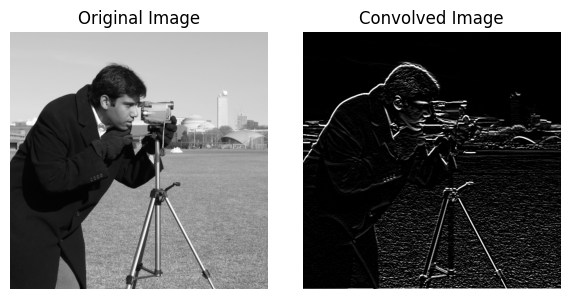

In [8]:
# Define kernel
kernel = sobel_y_kernel

# kernel = np.ones((5, 5), dtype=np.float32) / 9.0

# Apply convolution
convolved_img = convolve2d(img, kernel, stride=1, padding=1)  # padding=1 to preserve size

plot_images_grid([img, convolved_img], titles=["Original Image", "Convolved Image"], images_per_row=2, figsize=(6, 3), cmap = "gray")

### Convolution on RGB images

In [9]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

def convolve3d_custom(image, kernel):
    """
    Fast 3D convolution on RGB images (per-channel) using sliding windows.

    Args:
        image (np.ndarray): Color image (H x W x C)
        kernel (np.ndarray): 2D kernel (k x k)

    Returns:
        np.ndarray: Convolved and clipped image (H x W x C), dtype uint8
    """
    h, w, c = image.shape
    k, _ = kernel.shape
    pad = k // 2

    # Pad height and width only
    padded = np.pad(image, ((pad, pad), (pad, pad), (0, 0)), mode='edge')

    # Create sliding windows (h, w, k, k, c)
    strided_shape = (h, w, k, k, c)
    strided_steps = padded.strides[:2] + padded.strides[:2] + padded.strides[2:]
    windows = as_strided(padded, shape=strided_shape, strides=strided_steps)

    # Convolve: sum over (k, k), keep channels
    output = np.tensordot(windows, kernel, axes=([2, 3], [0, 1]))

    # Clip output to valid [0, 255] and convert to uint8
    output = np.clip(output, 0, 255).astype(np.uint8)

    return output


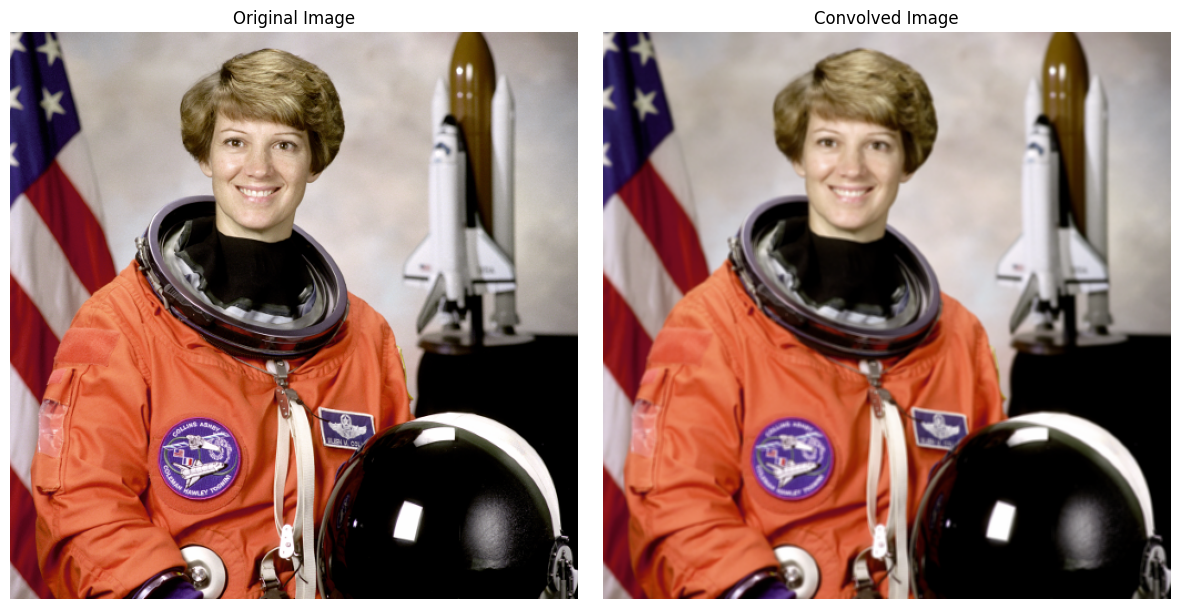

In [10]:
from skimage.data import astronaut # RGB image
img_rgb = astronaut().astype(np.float32)

# Example: simple 3D blur kernel
blur_kernel = np.ones((3, 3), dtype=np.float32) / 9.0

out_rgb = convolve3d_custom(img_rgb, blur_kernel)

plot_images_grid([img_rgb.astype(np.uint8), out_rgb], titles=["Original Image", "Convolved Image"], images_per_row=2, figsize=(12, 6))

## An image is a function?

In [90]:
import numpy as np
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'

import plotly.graph_objects as go

if img.ndim == 3:
    img_gray = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
else:
    img_gray = img

# create a 3D surface plot
fig = go.Figure(data=[go.Surface(z=img_gray)])
fig.update_layout(
    title='3D Surface Plot of Image',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Intensity'
    )
)
fig.show()

```{admonition} Fourier Transform for Images - Motivation and Foundations
:class: tip, dropdown, closed

1. How to View an Image in Fourier Space

A grayscale image is simply a 2D function:

$$
I(x, y) \quad \text{where} \quad (x, y) \in [0, H-1] \times [0, W-1].
$$

It tells you the **brightness** at each pixel location.

However, instead of thinking **pixel-by-pixel**,  
you can think of an image as a **combination of waves** of different frequencies.

Each image can be broken down into a sum of **sinusoidal waves** with different:
- Frequencies
- Orientations
- Amplitudes
- Phases

This "alternate view" is called the **Fourier space**.

2. What is the 2D Fourier Transform?

The **2D Discrete Fourier Transform (DFT)** of an image $I(x, y)$ is defined as:

$$
F(u, v) =
\sum_{x=0}^{H-1} \sum_{y=0}^{W-1}
I(x, y)\;
e^{-2\pi i \left( \frac{ux}{H} + \frac{vy}{W} \right)},
$$

where:
- $F(u, v)$ tells you **how much of the frequency (u, v)** exists in the image,
- $i = \sqrt{-1}$ is the imaginary unit,
- $u, v$ represent **frequencies** (not spatial positions).

3. What Does the Fourier Transform Give?

- **Magnitude** $|F(u, v)|$:  
  Strength (energy) of that frequency component.

- **Phase** $\arg(F(u, v))$:  
  Alignment (offset) of that frequency component.

Thus, Fourier space contains two important pieces:
- **What frequencies are present** (magnitude)
- **How they are arranged** (phase)

4. Why Move to Fourier Space?

- **Low frequencies** correspond to **smooth regions** (e.g., sky, walls).
- **High frequencies** correspond to **edges, textures, sharp changes**.

Fourier space lets you:
- Analyze or modify an image based on **frequency content**.
- Design filters (like blur, sharpen) more precisely.
- Perform **fast convolution** (because convolution becomes multiplication in Fourier domain).

5. Inverse Fourier Transform

You can reconstruct the original image from its Fourier coefficients:

$$
I(x, y) =
\frac{1}{HW} \sum_{u=0}^{H-1} \sum_{v=0}^{W-1}
F(u, v)\;
e^{2\pi i \left( \frac{ux}{H} + \frac{vy}{W} \right)}.
$$

Thus, **Fourier Transform** and **Inverse Fourier Transform** are perfect inverses of each other.

6. Key Insights

| Spatial Domain (Image)        | Fourier Domain (Frequency) |
|------------------------------|----------------------------|
| Pixel-by-pixel intensity       | Waves of different frequencies |
| Edges, shapes, textures        | High-frequency components |
| Smooth, flat regions           | Low-frequency components |
| Convolution is heavy (slow)    | Multiplication is fast |

```

In [11]:
# ---- FUNCTIONS CELL ----

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift
from numpy.lib.stride_tricks import as_strided

def pad_kernel(kernel, shape):
    """
    Zero-pad the kernel to match the image size and center it.
    """
    kh, kw = kernel.shape
    H, W = shape
    padded = np.zeros((H, W), dtype=np.float32)
    padded[:kh, :kw] = kernel
    padded = np.roll(padded, -kh // 2, axis=0)
    padded = np.roll(padded, -kw // 2, axis=1)
    return padded

def convolve2d_spatial(image, kernel):
    """
    Slow spatial domain convolution using explicit loops.
    """
    h, w = image.shape
    k, _ = kernel.shape
    pad = k // 2
    padded = np.pad(image, pad_width=pad, mode='edge')
    output = np.zeros_like(image)
    for i in range(h):
        for j in range(w):
            region = padded[i:i+k, j:j+k]
            output[i, j] = np.sum(region * kernel)
    return output

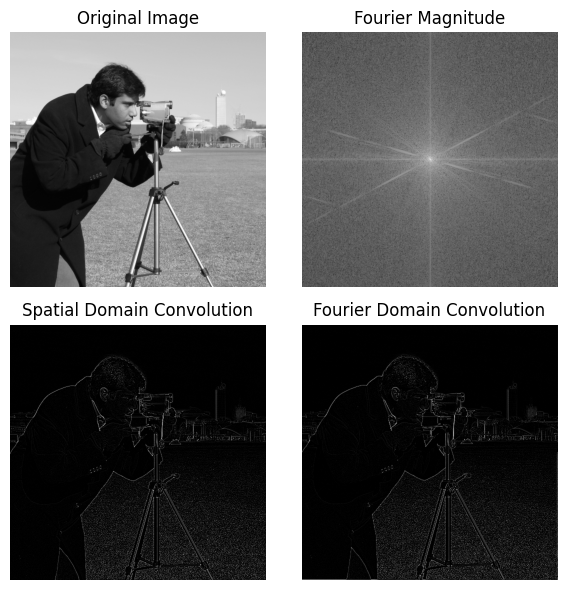

In [12]:
# ---- EXECUTION CELL ----

from skimage.data import camera

# Load grayscale image
img = camera().astype(np.float32)

# Define a kernel (Laplacian for edge detection)
kernel = np.array([
    [0, -1, 0],
    [-1, 4, -1],
    [0, -1, 0]
], dtype=np.float32)

# Step 1: Fourier Transform of Image
F_img = fft2(img)
magnitude_spectrum = np.log(1 + np.abs(fftshift(F_img)))  # Log for better visibility

# Step 2: Spatial Domain Convolution
out_spatial = convolve2d_spatial(img, kernel)
out_spatial = np.clip(out_spatial, 0, 255)

# Step 3: Fourier Domain Convolution
kernel_padded = pad_kernel(kernel, img.shape)
F_kernel = fft2(kernel_padded)
F_out = F_img * F_kernel
out_fourier = np.real(ifft2(F_out))
out_fourier = np.clip(out_fourier, 0, 255)

# Step 4: Plot all four images
plot_images_grid(
    images=[
        img.astype(np.uint8),
        magnitude_spectrum,
        out_spatial.astype(np.uint8),
        out_fourier.astype(np.uint8)
    ],
    titles=[
        "Original Image",
        "Fourier Magnitude",
        "Spatial Domain Convolution",
        "Fourier Domain Convolution"
    ],
    images_per_row=2,
    figsize=(6, 6),
    cmap="gray"
)

### How fast is Fourier Convolution?

In [13]:
import numpy as np
import time
from scipy.signal import convolve2d, fftconvolve

# Create a sample image and kernel
image_size = 1024     # Image: 1024 x 1024
kernel_size = 51      # Kernel: 51 x 51

image = np.random.rand(image_size, image_size)
kernel = np.random.rand(kernel_size, kernel_size)

# Time convolve2d
start_time = time.time()
output_convolve2d = convolve2d(image, kernel, mode='same')
time_convolve2d = time.time() - start_time

# Time fftconvolve
start_time = time.time()
output_fftconvolve = fftconvolve(image, kernel, mode='same')
time_fftconvolve = time.time() - start_time

# Time gain
time_gain = time_convolve2d / time_fftconvolve

# Output
print(f"convolve2d time:   {time_convolve2d:.5f} seconds")
print(f"fftconvolve time:  {time_fftconvolve:.5f} seconds")
print(f"Time gain (conv2d / fft): {time_gain:.2f}x")
print(f"Outputs match? {np.allclose(output_convolve2d, output_fftconvolve, atol=1e-5)}")

convolve2d time:   4.24693 seconds
fftconvolve time:  0.01665 seconds
Time gain (conv2d / fft): 255.12x
Outputs match? True


## Neural Networks as Function Approximators

At a high level, **neural networks** are simply **function approximators**.

They take in data points like $x_1, x_2, \dots, x_n$ (usually represented as **tensors**) and **learn** to predict the corresponding labels $y_1, y_2, \dots, y_n$.

Formally, a neural network tries to approximate a mapping:

$$
f_\theta(x) \approx y,
$$

where:
- $x$ is the input,
- $y$ is the target output,
- $f_\theta$ is the neural network, parameterized by weights $\theta$,
- Learning is the process of adjusting $\theta$ to minimize the prediction error.

---

### Two Main Components of a Neural Network

A neural network is generally composed of two main parts:

1. **Feature Extractor Module**  
   - This part processes raw input data into **useful internal representations**.
   - It can be a series of convolutional layers (in images), RNNs (for sequences), or just dense layers.
   - Good feature extraction makes the next step easier.

2. **Task-Specific Head**  
   - This part uses the extracted features to **solve a specific task**.
   - Example tasks include classification, regression, segmentation, etc.
   - Often consists of one or more fully connected (dense) layers.

---

### Quick Example: TensorFlow Playground

To visualize this, we can take a look at the [TensorFlow Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.75860&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).

On this website:
- You can see how neural networks learn to **extract features** from the input space.
- You can observe how **different architectures** affect learning and decision boundaries.
- You can interactively modify network shape, learning rates, and visualize how the model improves over time.

---

### Visual Representation of a Simple Neural Network

Below is a simple diagram showing a basic feedforward neural network:

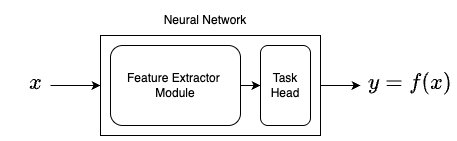

In [94]:
from IPython.display import Markdown, display

with open("../figures/nn.txt", "r") as file:
    base64_image = file.read().strip()

markdown_code = f'<img src="{base64_image}" style="max-width:100%;" />'
display(Markdown(markdown_code))

## Understanding Feature Extraction in Convolutional Neural Networks (CNNs)

---

### 1. Intuition: How CNNs Extract Features

In traditional fully connected networks (MLPs), every neuron is connected to every pixel.  
However, in images, nearby pixels are more related than distant pixels.  
Thus, local patterns such as edges, textures, and simple shapes are critical to understand an image.

Convolutional Neural Networks (CNNs) use small filters (kernels) that slide across the image and detect these local patterns.

Each filter focuses on extracting specific features such as:
- Edges
- Corners
- Blobs
- Textures

These extracted local patterns are organized into feature maps.

---

### 2. Mathematical Definition of Convolution in CNNs

Given:
- Input image $I \in \mathbb{R}^{H \times W}$,
- Convolutional kernel $K \in \mathbb{R}^{k \times k}$,
- Stride $s$,
- Padding $p$,

the output feature map $O \in \mathbb{R}^{H_{\text{out}} \times W_{\text{out}}}$ is computed as:

$$
O(i, j) = \sum_{u=0}^{k-1} \sum_{v=0}^{k-1} I(i \times s + u, j \times s + v) \cdot K(u, v)
$$

where:

$$
H_{\text{out}} = \left\lfloor \frac{H + 2p - k}{s} \right\rfloor + 1, \quad W_{\text{out}} = \left\lfloor \frac{W + 2p - k}{s} \right\rfloor + 1
$$

At each position, the kernel computes a weighted sum over a small patch of the input image, producing one output pixel.

---

### 3. Where Are Features Learned?

The convolutional kernels themselves are learned during training through backpropagation.  
Initially, the filters are random. As training progresses, the network updates the kernel weights to detect important patterns that help minimize classification error.

Each output channel in a convolutional layer corresponds to a different feature map, detected by a different kernel.  
Thus:
- Each kernel learns to recognize a specific pattern.
- The number of output channels is equal to the number of filters.

For example:
- 1 input channel (grayscale image),
- 32 filters,

results in an output with 32 learned feature maps.

Features are stored and represented across the multiple channels.

---

### 4. Why Max Pooling?

After convolution, the feature maps still contain a lot of redundant information, including slight variations or small shifts.  
Max pooling helps by:
- Keeping only the strongest activations (important features),
- Making the network more robust to small translations or distortions,
- Reducing the spatial size of the feature maps, thus reducing computation and parameters.

#### Max Pooling Operation

Given a pooling window of size $p \times p$,  
for each window, the output is the maximum value:

$$
O(i, j) = \max_{(u,v) \in p \times p \text{ window}} I(u,v)
$$

For example, for a $2 \times 2$ pooling:

| 2×2 Window | Max Pool |
|:----------:|:--------:|
| 1 3 |
| 2 4 | → 4 |

Only the maximum value (4) is retained.

---

### 5. Overall Flow of a CNN Layer

| Step | Action |
|:----|:-------|
| Convolution | Detect local patterns using small kernels |
| Activation (ReLU) | Introduce non-linearity |
| Max Pooling | Downsample feature maps and focus on important features |
| Repeat | Stack multiple layers to build increasingly complex representations |

---

### 6. Summary

- CNNs extract hierarchical features from images.
- Convolutional kernels are learned automatically during training.
- Each output channel corresponds to a different learned feature map.
- Max pooling improves translation invariance and reduces redundancy.
- Stacking multiple convolution and pooling layers allows the network to detect edges at first, then textures, and finally complex structures or objects.

---